# Steiner networks

In [1]:
# Import standard libraries
from importlib import reload
import csv
import OmicsIntegrator as oi
import networkx as nx
import community 
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
import time
from upsetplot import from_contents, UpSet
from sklearn.cluster import AgglomerativeClustering
from IPython.display import Image
from IPython.core.display import SVG
import gseapy
from gseapy.plot import barplot, dotplot
from scipy import stats
import random
import itertools

# Import custom libraries
import pcst_utils as pcst

In [2]:
# Reload modules in case of modifications
reload(pcst)

<module 'pcst_utils' from '/home/braunger/masterthesis/relevant_code/Python/Steiner_networks/pcst_utils.py'>

In [3]:
# File paths
data_dir = "/home/braunger/masterthesis/data/"
save_dir = "/home/braunger/masterthesis/save/pcst/"
tf_dir = "/home/braunger/masterthesis/save/TF_targets/"
de_dir = "/home/braunger/masterthesis/save/DE_genes/"
fig_dir = "/home/braunger/masterthesis/save/figures/pcst/"

# 1. Descriptive Statistics of the network (design 2)

In [4]:
net_dict = pcst.get_net_dir_all_stages(save_dir, "allTFs", "200", design = 2)
steps = ["1-15_16-26_27-60", "16-26_27-60_61-85", "27-60_61-85_86-96"]
net_stats_d2, target_counts_d2 = pcst.compare_networks(net_dict, data_dir, fig_dir, save_dir, steps, 
                                                 TFs_with_targets = True, design = 2)

net_stats_d2.iloc[:, 0:8]

,n_nodes,n_edges,n_incl_terminals,percent_incl_terminals,n_Steiner_nodes,n_TFs,n_incl_TFs,n_prized_TFs
1-15_16-26_27-60,529,5320,289,96.333333,240,274,51,6
16-26_27-60_61-85,491,4788,260,96.654275,231,259,59,1
27-60_61-85_86-96,465,5070,270,86.261981,195,279,56,4


In [5]:
pcst.save_net_html(net_dict['200.allTFs.1-15_16-26_27-60'], net_stats_d2.loc['1-15_16-26_27-60', 'incl_TFs'],
                  save_dir, '200.allTFs.1-15_16-26_27-60', '2')
pcst.save_net_html(net_dict['200.allTFs.27-60_61-85_86-96'], net_stats_d2.loc['27-60_61-85_86-96', 'incl_TFs'],
                  save_dir, '200.allTFs.27-60_61-85_86-96', '2')

,protein,transition,name,category,TF,group
0,UBE2D2,tr0,UBE2D2_tr0,Steiner node,No bridge TF,left
1,PPP2CA,tr0,PPP2CA_tr0,Steiner node,No bridge TF,left
2,PLK4,tr1,PLK4_tr1,DE_tr1,No bridge TF,right
3,CTNNB1,tr0,CTNNB1_tr0,Steiner node,No bridge TF,left
4,TRMT112,tr0,TRMT112_tr0,Steiner node,No bridge TF,left
...,...,...,...,...,...,...
460,RPS17,tr0,RPS17_tr0,DE_tr0,No bridge TF,left
461,CCDC85C,tr1,CCDC85C_tr1,DE_tr1,No bridge TF,right
462,SIRT1,tr0,SIRT1_tr0,Steiner node,No bridge TF,left
463,SMAD1,tr0,SMAD1_tr0,DE_tr0,No bridge TF,left


/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  del sys.path[0]


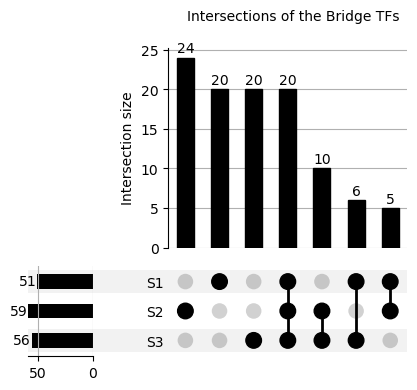

In [6]:
incl_TFs_2 = [[tf[:-4] for tf in net_stats_d2.iloc[net, 9]] for net in range(3)]
shared_TFs_design2 = set.intersection(*map(set,incl_TFs_2))
intersections = from_contents({'S3': incl_TFs_2[2], 
                               'S2': incl_TFs_2[1],
                               'S1': incl_TFs_2[0]})
intersections['S1'] = intersections.index.get_level_values(0)
intersections['S2'] = intersections.index.get_level_values(1)
intersections['S3'] = intersections.index.get_level_values(2)
intersections['group'] = intersections['S1'].astype(str)+'_'+intersections['S2'].astype(str)+'_'+intersections['S3'].astype(str)

intersections['group'] = intersections['group'].astype('category')
intersections['group'].cat.reorder_categories(['False_True_False', 'False_False_True', 'True_False_False', 'True_True_True',
                      'True_True_False', 'True_False_True', 'False_True_True'], inplace=True)
intersections = intersections.sort_values(by = 'group')

matplotlib.rc_file_defaults()
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by=None, min_subset_size = 2, sort_categories_by=None).plot()
plt.figtext(0.45, 0.95, 'Intersections of the Bridge TFs')
plt.savefig(fig_dir+'intersections_design2.png', dpi = 500, bbox_inches="tight")

In [7]:
# save incl TFs as dataframe
incl_TFs_df = pd.DataFrame({'TF': list(itertools.chain(*incl_TFs_2)), 
                            'net': list(itertools.chain(*[['young_net'] * len(incl_TFs_2[0]), 
                                                          ['middle_net'] * len(incl_TFs_2[1]), 
                                                          ['old_net'] * len(incl_TFs_2[2])]))})
incl_TFs_df.to_csv(save_dir + 'incl_TFs_design2.csv', index = False)

# 2. Analysis of the Steiner nodes

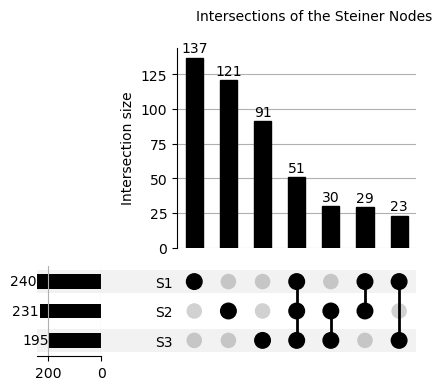

In [8]:
steiner_nodes = [[node[:-4] for node in net_stats_d2.iloc[net, 11]] for net in range(3)]

intersections = from_contents({'S3': steiner_nodes[2], 
                               'S2': steiner_nodes[1],
                               'S1': steiner_nodes[0]})
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 5, sort_categories_by=None).plot()
plt.figtext(0.45, 0.95, 'Intersections of the Steiner Nodes')
plt.savefig(fig_dir+'intersections_steiner_10%.png', dpi = 500, bbox_inches="tight")

In [9]:
# Steiner nodes included in all networks
shared_nodes = [node + '_tr0' for node in set.intersection(*map(set,steiner_nodes[:3]))]
degrees_steiner_nodes = pd.DataFrame(index = shared_nodes)

for name, net in net_dict.items():
    degrees = pd.DataFrame(net.degree(shared_nodes)).set_index(0)
    degrees.columns = [name.split("-")[2]]
    degrees_steiner_nodes = degrees_steiner_nodes.join(degrees)

shared_nodes = [node[:-4] for node in shared_nodes]
print(*shared_nodes, sep = ", ")

HDAC1, HIF1A, BCL2L1, ATF1, HSPA5, CTNNB1, GNB1, MFAP2, TRAF6, NCOR1, LRP6, TGFBR1, RPS27A, TP53, NOTCH1, ITGB1, STAT1, HOXA6, JAK2, KLF3, CBL, FLI1, EGFR, CYCS, TNFRSF1A, NR2C2, GTF2B, APP, STAT3, HSP90AA1, POLR2A, TAB2, RANBP2, HDAC6, AHR, WNT5A, SMAD4, AXIN1, DLG4, ZNF384, MAZ, FYN, SHC1, TSG101, TRADD, FOXO3, RACK1, SRC, HRAS, POLR2B, GATA2


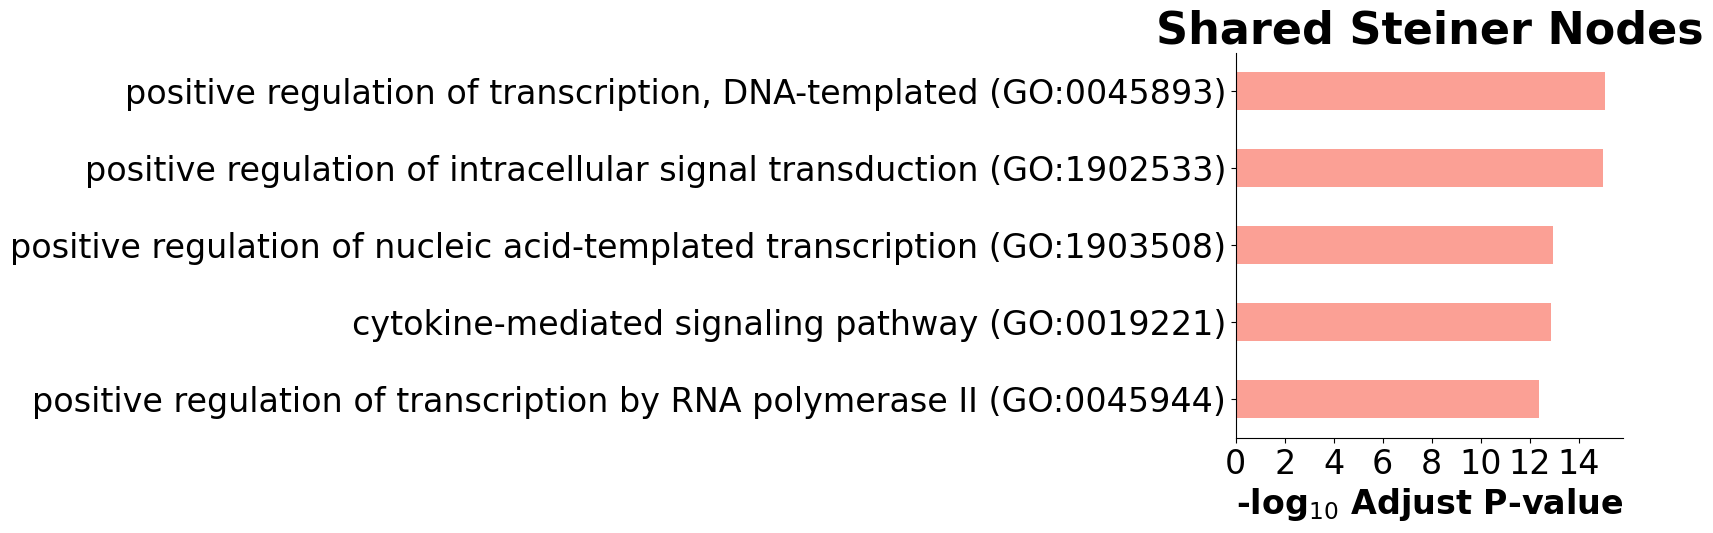

In [10]:
# GSEA on the shared Steiner nodes
enr = gseapy.enrichr(gene_list=shared_nodes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='', outdir=save_dir+'GO_steiner', format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='Shared Steiner Nodes',
        cutoff=0.01, top_term=5, figsize=(5, 5), color='salmon')

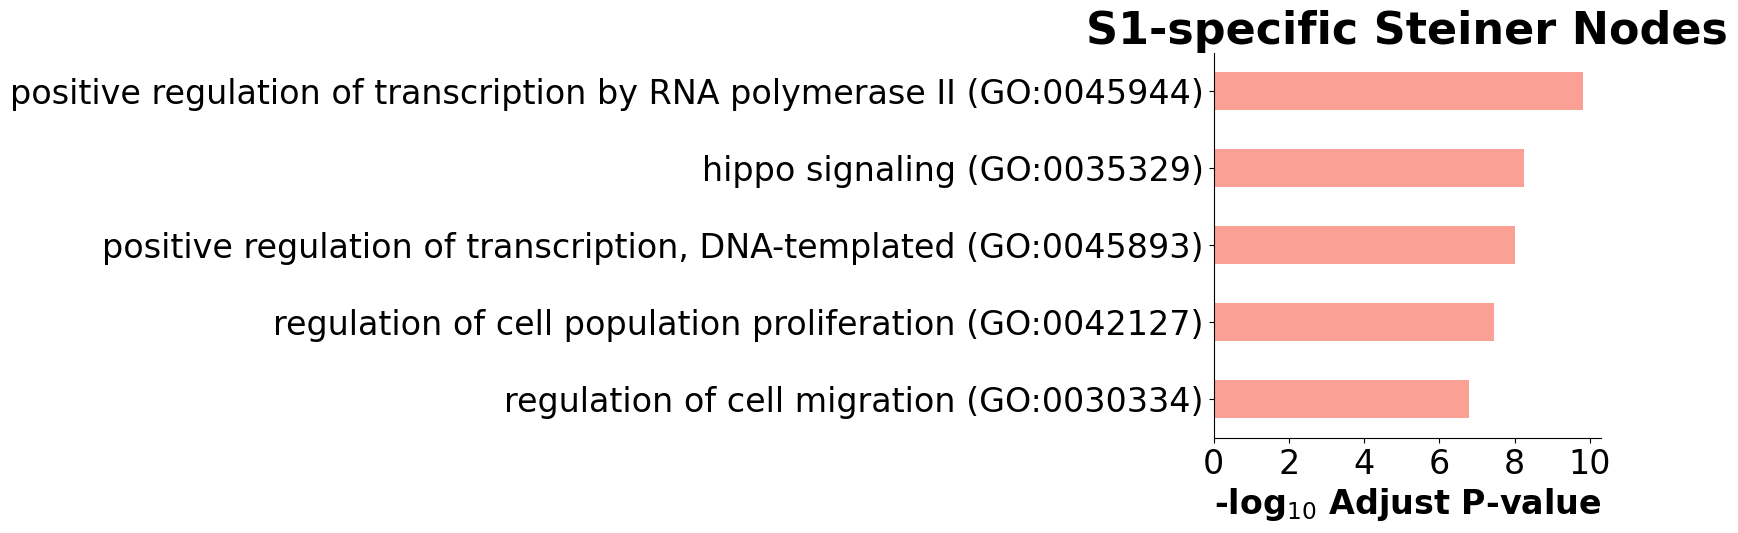

In [11]:
# GSEA on the Steiner nodes from the first network
first_nodes = list(set(steiner_nodes[0]).difference(set(steiner_nodes[1]).union(steiner_nodes[2])))

enr = gseapy.enrichr(gene_list=first_nodes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='', outdir=save_dir+'GO_steiner', format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='S1-specific Steiner Nodes',
        cutoff=0.01, top_term=5, figsize=(5, 5), color='salmon')

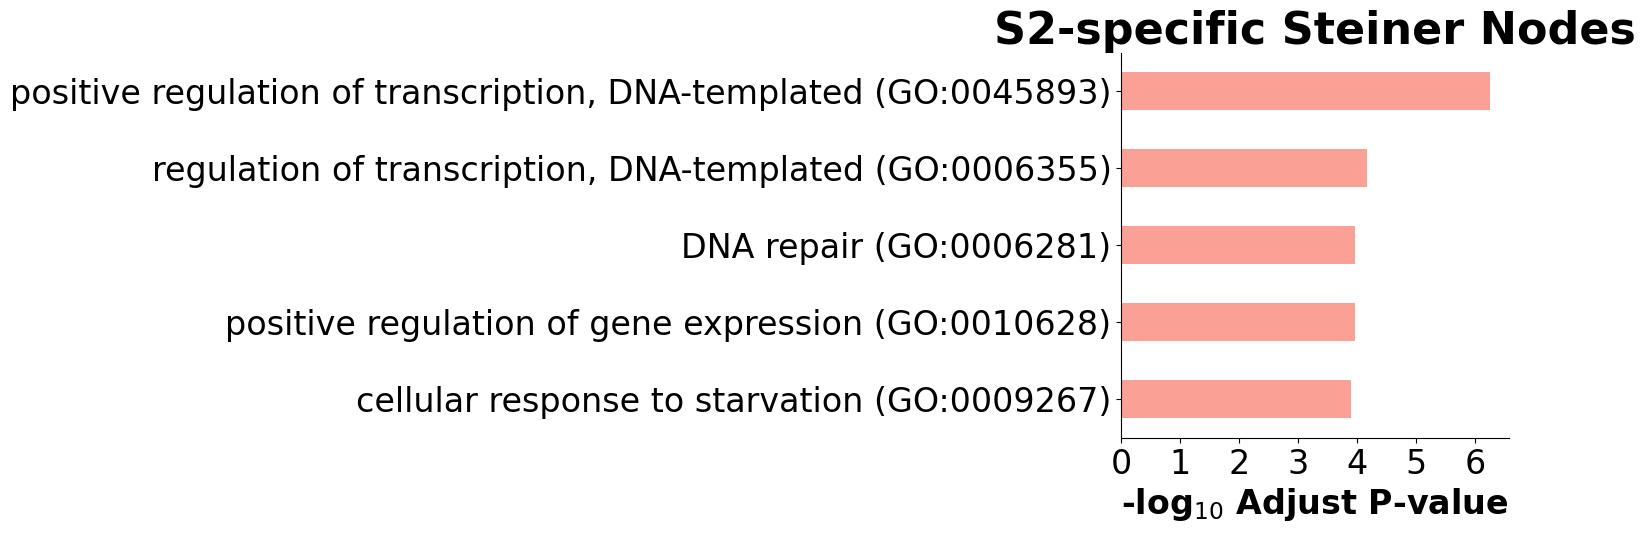

In [12]:
# GSEA on the Steiner nodes from the second network
second_nodes = list(set(steiner_nodes[1]).difference(set(steiner_nodes[0]).union(steiner_nodes[2])))

enr = gseapy.enrichr(gene_list=second_nodes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='', outdir=save_dir+'GO_steiner', format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='S2-specific Steiner Nodes',
        cutoff=0.01, top_term=5, figsize=(5, 5), color='salmon')

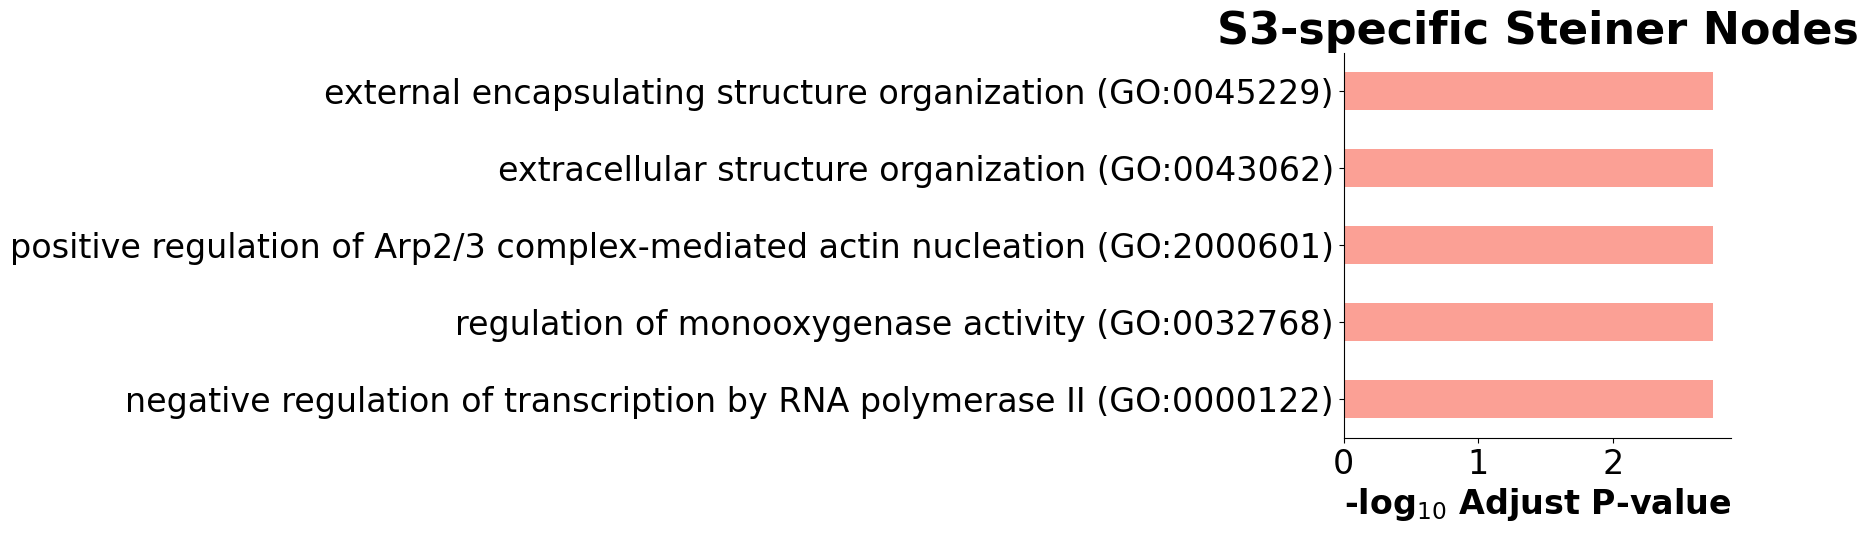

In [13]:
# GSEA on the Steiner nodes from the first network
last_nodes = list(set(steiner_nodes[2]).difference(set(steiner_nodes[1]).union(steiner_nodes[0])))

enr = gseapy.enrichr(gene_list=last_nodes, 
                     gene_sets='GO_Biological_Process_2021', 
                     description='', outdir=save_dir+'GO_steiner', format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='S3-specific Steiner Nodes',
        cutoff=0.01, top_term=5, figsize=(5, 5), color='salmon')

# 3. Regulatory relationships between TF groups

In [14]:
def first_net_TFs(incl_TFs):
    return set(incl_TFs[0]).difference(set.union(*map(set,[incl_TFs[i] for i in [1, 2]])))
def second_net_TFs(incl_TFs):
    return set(incl_TFs[1]).difference(set.union(*map(set,[incl_TFs[i] for i in [0, 2]])))
def last_net_TFs(incl_TFs):
    return set(incl_TFs[2]).difference(set.union(*map(set,incl_TFs[0:2])))

# Create networks of targeting between the TFs for each TF groups as html and print network density (number of edges / number of nodes)
print('Network density for TFs targeting others of their group')
print('Shared TFs', pcst.TF_redundancy(list(shared_TFs_design2), 'shared_TFs', data_dir, save_dir))
print('First net TFs', pcst.TF_redundancy(list(first_net_TFs(incl_TFs_2)), 'first_net_TFs', data_dir, save_dir))
print('Middle net TFs', pcst.TF_redundancy(list(second_net_TFs(incl_TFs_2)), 'second_net_TFs', data_dir, save_dir))
print('Last net TFs', pcst.TF_redundancy(list(last_net_TFs(incl_TFs_2)), 'last_net_TFs', data_dir, save_dir))
incl_TFs = list(set([TF for TF_list in incl_TFs_2 for TF in TF_list]))
np.random.seed(202211)
random_TFs = np.random.choice(incl_TFs, 20)
print('Random TFs', pcst.TF_redundancy(random_TFs, 'random_TFs', data_dir, save_dir))

Network density for TFs targeting others of their group
Shared TFs 6.1
First net TFs 4.2
Middle net TFs 4.708333333333333
Last net TFs 4.05
Random TFs 5.45


In [15]:
# get p-values based on random TF distribution
eps_list = []
for sim in tqdm(range(1000)):
    time.sleep(0.01)
    np.random.seed(202211+sim)
    random_TFs = np.random.choice(incl_TFs, 20)
    epsilon = pcst.TF_redundancy(random_TFs, 'random_TFs', data_dir, save_dir)
    eps_list.append(epsilon)
    
print('Mean for random TFs: ', np.mean(eps_list))
print('P-value for shared TFs: ', len([epsilon for epsilon in eps_list if 6.1 < epsilon]) / len(eps_list))
print('P-value for young TFs: ', len([epsilon for epsilon in eps_list if 4.2 < epsilon]) / len(eps_list))
print('P-value for middle TFs: ', len([epsilon for epsilon in eps_list if 4.7 < epsilon]) / len(eps_list))
print('P-value for old TFs: ', len([epsilon for epsilon in eps_list if 4.05 < epsilon]) / len(eps_list))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [38:11<00:00,  2.29s/it]

Mean for random TFs:  4.0807
P-value for shared TFs:  0.049
P-value for young TFs:  0.43
P-value for middle TFs:  0.288
P-value for old TFs:  0.485


# 4. TF centrality

In [16]:
# per TF get number of PPI edges and TF-target edges and Katz centrality
net_dict = pcst.get_net_dir_all_stages(save_dir, "allTFs", "200", design = 2)
all_TFs = [TF + '_tr0' for TF_list in incl_TFs_2 for TF in TF_list]

# load all TF targets
all_tf_targets = pd.read_csv(tf_dir+'TF_targets_anno.csv')
all_genes = pd.read_csv(de_dir+'all_genes.csv')
all_tf_targets = all_tf_targets[all_tf_targets['target'].isin(all_genes['gene'])]

TFs_centrality = pd.DataFrame(columns = ['TF', 'net', 'katz_centrality', 'PPIs', 'DE_targets', 'all_targets'])
count = 0

for name, net in net_dict.items():
    # calculate Katz centrality for each node in the network
    # largest eigenvalue phi
    phi = np.max(np.abs(np.linalg.eigh(np.array(nx.adjacency_matrix(net).todense()))[0]))
    centrality = nx.katz_centrality(net, alpha=1/phi-0.01)
    for TF in incl_TFs_2[count]:
        life_stage = name.split(".")[2]
        neighbors = [n[-1] for n in net.neighbors(TF + '_tr0')]
        n_targets = all_tf_targets[all_tf_targets['TF'] == TF].shape[0]
        row = pd.DataFrame({'TF': [TF], 'net': [life_stage], 
                            'katz_centrality': centrality[TF+ '_tr0'],
                            'PPIs': [neighbors.count('0')], 
                            'DE_targets': [neighbors.count('1')], 
                            'all_targets': [n_targets]})
        TFs_centrality = pd.concat([TFs_centrality, row], ignore_index = True)
    count = count + 1
TFs_centrality = TFs_centrality.replace(['1-15_16-26_27-60', '16-26_27-60_61-85', '27-60_61-85_86-96'], 
                                       ['young', 'middle', 'old'])
TFs_centrality.to_csv(save_dir + 'TFs_centrality.csv', index = False)
TFs_centrality.head()

,TF,net,katz_centrality,PPIs,DE_targets,all_targets
0,HOXA13,young,0.027908,4,1,17
1,SIN3A,young,0.075271,36,35,2205
2,HDAC6,young,0.059554,37,1,94
3,NOTCH1,young,0.104882,53,70,5798
4,PML,young,0.062968,40,6,543


# 5. Circular plot of amount of shared targets

In [17]:
# Use a hypergeometric distribution to get p-values for number of shared targets between TF pairs
# load DE genes and TF groups with their targets
DE_genes = pd.read_csv(data_dir+'de_data/DE_var_p_n_200.csv')
transitions = ['fc_16-26_27-60', 'fc_27-60_61-85', 'fc_61-85_86-96']    
DE_genes = DE_genes[DE_genes['transition'].isin(transitions)]
TF_groups = pd.read_csv(save_dir+'specific_TFs_targets.csv')
TF_groups = TF_groups[TF_groups['target'].isin(DE_genes['gene'])]
n_DE_genes =  len(TF_groups['target'].unique()) # M = total number of objects

# get TFs 
TFs = TF_groups['TF'].unique()
TF_pairs = list(itertools.combinations(TFs, 2))

shared_targets = pd.DataFrame({'TF1': [], 'TF2': [], 'pval': [], 'proportion': []})

for TF_pair in tqdm(TF_pairs):
    time.sleep(0.01)
    TF1, TF2 = TF_pair

    targets_TF1 = set(TF_groups[TF_groups['TF'] == TF1]['target']) # n = total number of type 1 objects
    targets_TF2 = set(TF_groups[TF_groups['TF'] == TF2]['target']) # N = number of draws wo replacement
    shared = targets_TF1.intersection(targets_TF2)
    pval = stats.hypergeom.sf(len(shared) - 1, n_DE_genes, len(targets_TF1), len(targets_TF2))
    percent = len(shared) / len(targets_TF1.union(targets_TF2))
    row = pd.DataFrame({'TF1': [TF1], 'TF2': [TF2], 'pval': [pval], 'proportion': [percent]})
    shared_targets = pd.concat([shared_targets, row], ignore_index = True)

shared_targets.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3486/3486 [00:51<00:00, 67.82it/s]


,TF1,TF2,pval,proportion
0,HOXA6,AHR,9.083280e-01,0.016129
1,HOXA6,FLI1,6.265340e-02,0.099415
2,HOXA6,POLR2A,1.006294e-10,0.210884
3,HOXA6,TCF7L2,5.268849e-01,0.022222
4,HOXA6,SRC,2.940330e-02,0.108108


In [18]:
# define TF colors
TF_colors = TF_groups[['TF', 'net']].copy().drop_duplicates()
TF_colors['color'] = TF_colors['net'].replace(['shared', 'young_net', 'middle_net', 'old_net'], ['black', 'blue', 'green', 'orange'])

# define TF sizes
TF_sizes = pd.DataFrame(TF_groups['TF'].value_counts())
TF_sizes['TF_name'] = TF_sizes.index
TF_sizes.columns = ['n_targets', 'TF']

TF_annotation = pd.merge(TF_colors, TF_sizes, on = ['TF'])
TF_annotation = TF_annotation.sort_values(by = 'n_targets')
TF_annotation.tail()

,TF,net,color,n_targets
66,CDK9,old_net,orange,270
12,HDAC1,shared,black,288
37,EP300,young_net,blue,321
2,FLI1,shared,black,338
14,MAZ,shared,black,377


(128, 4)


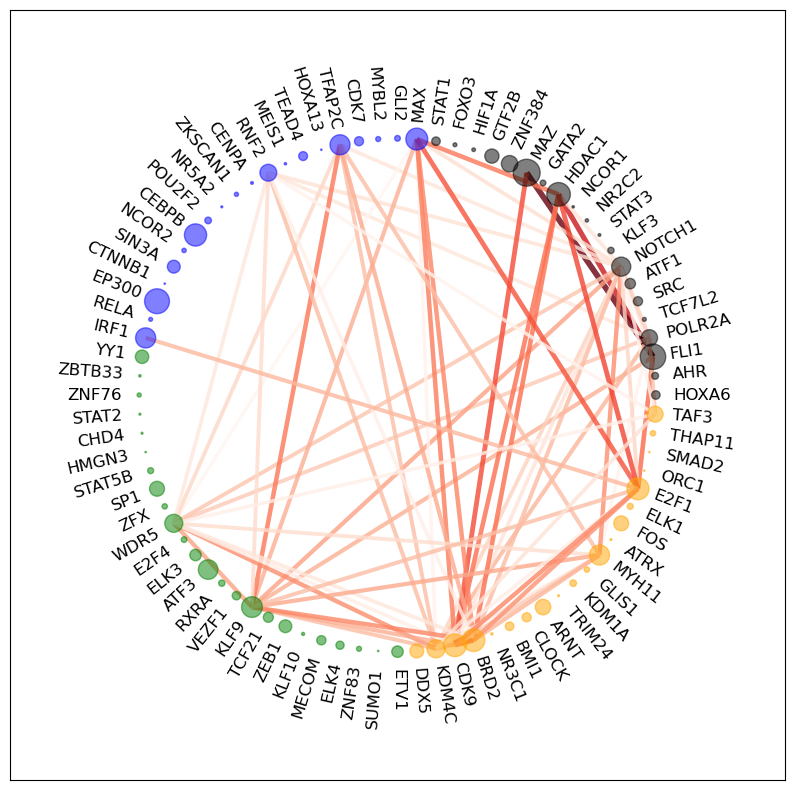

In [19]:
network = nx.from_pandas_edgelist(shared_targets, 'TF1', 'TF2', 'pval')

plt.figure(figsize = (10,10))
# Draw
pos = nx.circular_layout(network)

# Draw terminals 
nx.draw_networkx_nodes(network, 
                       pos,
                       nodelist = TF_annotation['TF'],
                       node_color = TF_annotation['color'], 
                       node_size = TF_annotation['n_targets'],
                       node_shape = 'o',
                       alpha = 0.5)

# Draw edges 
shared_targets_subset = shared_targets[shared_targets['pval'] < 1e-15].reset_index(drop=True)
print(shared_targets_subset.shape)
shared_targets_subset = shared_targets_subset[shared_targets_subset['proportion'] > 0.5].reset_index(drop=True)

selected_edges = [(shared_targets_subset.iloc[ix,:]['TF1'], shared_targets_subset.iloc[ix,:]['TF2']) 
                  for ix in shared_targets_subset.index]
nx.draw_networkx_edges(network, 
                       pos, 
                       edgelist = selected_edges,
                       width= shared_targets_subset['proportion']*5, 
                       alpha=0.8, 
                       edge_color= shared_targets_subset['proportion'],
                       edge_cmap=plt.cm.Reds)

# Draw labels
theta = {k: np.arctan2(v[1], v[0]) * 180/np.pi for k, v in pos.items()} #gets degree of node positions
new_pos = {TF: np.array([x + np.cos(np.deg2rad(theta[TF]))/15, y + np.sin(np.deg2rad(theta[TF]))/15]) 
           for TF, (x,y) in pos.items()}
labels = nx.draw_networkx_labels(network,
                        new_pos,
                        font_size=12, 
                        ha='left')
# rotate the labels
for key,t in labels.items():
    if 90 < theta[key] or theta[key] < -90 :
        angle = 180 + theta[key]
        t.set_ha('right')
    else:
        angle = theta[key]
        t.set_ha('left')
    t.set_va('center')
    t.set_rotation(angle)
    t.set_rotation_mode('anchor')

plt.box("off")
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.savefig(fig_dir + 'TF_target_sharing.png', dpi = 500, bbox_inches="tight")
plt.show()

# 6.  Hypergeometric test to identify TFs targeting significantly more DE genes

In [20]:
# Hypergeometric confidence interval for one network
network = "young"

if network == "young": 
    transition = "fc_16-26_27-60"
elif network == "middle":
    transition = "fc_27-60_61-85"
elif network == "old": 
    transition = "fc_61-85_86-96"

# Hypergeometric parameters N and K
N = all_genes.shape[0] # total number of genes
DE_genes = pd.read_csv(data_dir+'de_data/DE_var_p_n_200.csv')
DE_genes = DE_genes[DE_genes['transition'] == transition]
K = DE_genes.shape[0] # total number of DE genes

# Calculate percentage of all genes and DE genes targeted by each TF
TF_percent_targets = TFs_centrality[TFs_centrality['net'] == network]
TF_percent_targets['prop_genome_targets'] = TF_percent_targets['all_targets'] / all_genes.shape[0]
TF_percent_targets['prop_DE_targets'] = TF_percent_targets['DE_targets'] / DE_genes.shape[0]
TF_percent_targets = TF_percent_targets.set_index('TF')

# Sequence of hyper geometric parameter n
q_list = np.logspace(-4,0,1000)
n_list = [int(q*N) for q in q_list]

# Lower and upper bound of (right-sided) CI
alpha = 0.05/TF_percent_targets.shape[0] # level of confidence interval
ci_lowerbound = np.repeat(0, len(q_list))
ci_upperbound = np.array([ss.hypergeom.ppf(1-alpha, N, K, n, loc=0) for n in n_list])/K

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


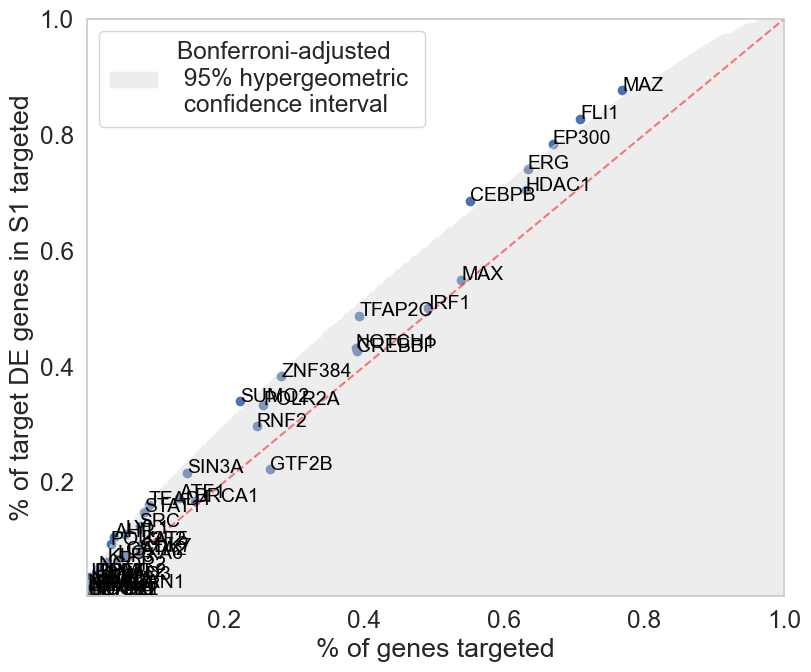

In [21]:
# Plot TFs on prop_genome_targets - prop_DE_targets space for one network
sns.set(font_scale=1.6)
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(figsize=(9,7.5))
x = TF_percent_targets['prop_genome_targets']
y = TF_percent_targets['prop_DE_targets']
labels = TF_percent_targets.index.values
ax.scatter(x, y)
ax.plot((0,1),(0,1), color='red', linestyle='dashed', alpha=0.5)
ax.fill_between(q_list, ci_lowerbound, ci_upperbound, where=None, facecolor='lightgrey', 
                interpolate=False, alpha=0.4, 
                label='Bonferroni-adjusted \n 95% hypergeometric \n confidence interval')
for i in range(TF_percent_targets.shape[0]):
    ax.annotate(labels[i], (x[i], y[i]), size=14, color='black')
plt.xlabel('% of genes targeted')
plt.ylabel('% of target DE genes in S1 targeted')
plt.legend(loc='upper left')
plt.xlim([4e-3,1])
plt.ylim([3e-3,1])
plt.savefig(fig_dir+'hypergeom_young_TFs.png', dpi = 500, bbox_inches="tight")
plt.show()

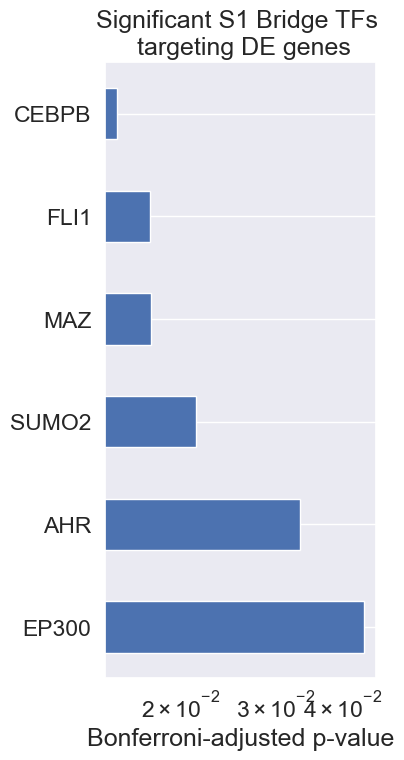

Number of significant TFs = 6


In [22]:
# Compute adjusted p-values
pvals = [ss.hypergeom.sf(TF_percent_targets.loc[tf,'prop_DE_targets']*K - 1, 
                         N, 
                         K, 
                         TF_percent_targets.loc[tf,'prop_genome_targets']*N)*TF_percent_targets.shape[0]
         for tf in TF_percent_targets.index]
TF_p_values = pd.concat(
    [TF_percent_targets, pd.DataFrame({'adj_pval': pvals}, index=TF_percent_targets.index)], 
    axis=1
)
TF_p_values['adj_pval'] = TF_p_values['adj_pval'].fillna(1)

# Barplot of significant TFs
TF_p_values = TF_p_values.sort_values(by='adj_pval', ascending=False)

sns.set(font_scale=1.5)
plt.figure(figsize=(3.5,8))
TF_p_values[TF_p_values['adj_pval']<0.05]['adj_pval'].plot.barh()
plt.xscale('log')
plt.xlabel('Bonferroni-adjusted p-value')
plt.ylabel('')
plt.title('Significant S1 Bridge TFs \n targeting DE genes')
plt.savefig(fig_dir+'signif_young_TFs.png', dpi = 500, bbox_inches="tight")
plt.show()

significant_tfs = TF_p_values[TF_p_values['adj_pval']<0.05].index.values
print(f'Number of significant TFs = {len(significant_tfs)}')

# Save df containing the adjusted p-values
TF_p_values['TF'] = TF_p_values.index.values
TF_p_values.to_csv(save_dir + 'TFs_centrality_' + network + '.csv', index = False)